#### This notebook is created as submission for Assignment 01, Analytics for Unstructured Data
Submitted by: Ruchi Sharma 

In this assignment you have been hired as an analytics consultant by JD power and Associates, who wants to perform a competitive analysis of the entry level luxury car market in the USA. Your job is to give advice/insights to these individuals based on the analysis of social media conversations

1.	Write a scraper to fetch messages posted in Edmunds.com discussion forums. The scraper output should be a .csv file with the following columns: date and message (even though you will only use the messages in your analysis). Before you develop the scraper, carefully study one of the forums on Edmunds.com to understand the html design as well as the threading structures. 

2.	 Fetch around 5000 posts about cars from the Entry Level Luxury forum https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans -- The idea is to have multiple brands and models being discussed without one of them being the focal point. You can choose early or recent posts (do mention what you have chosen). Note that Edmunds changed its forum structure a few years ago, but left the early posts with the old structure. So you should choose either the oldest or newest posts. 

In [1]:
import pandas as pd
data = pd.read_csv("scraped_data_1.csv", index_col = 0)

Task A: Once you fetch the data, test if the data support Zipf’s law econometrically. Also plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization. 

Check http://www.garysieling.com/blog/exploring-zipfs-law-with-python-nltk-scipy-and-matplotlib 
(Note that the above link does not test Zipf’s law econometrically)


In [2]:
data1 = data.copy()
data1 = data1.dropna()

test = data1['comment']

okay = {} 

for elem in test:
    elem_split = elem.split() 
    
    for elem3 in elem_split:      
        if elem3 not in okay:
            okay[elem3] = 1
        elif elem3 in okay:
            okay[elem3] += 1
            
freq_list = sorted(okay.items(), key=lambda x: x[1], reverse=True)

print("Top 20: \n", freq_list[:20], "\n\n", "Bottom 20: \n", freq_list[-20:])

Top 20: 
 [('the', 19660), ('a', 10839), ('I', 9025), ('and', 8507), ('to', 8287), ('of', 5527), ('is', 5423), ('in', 5203), ('for', 4031), ('it', 4004), ('that', 3944), ('on', 3694), ('with', 3278), ('have', 2546), ('you', 2487), ('my', 2422), ('was', 2396), ('but', 2349), ('are', 2172), ('The', 2167)] 

 Bottom 20: 
 [('pilgrimage', 1), ('tilted,', 1), ('rotating', 1), ('(read:', 1), ('hideous,', 1), ('also),', 1), ('(another', 1), ('mine),', 1), ('86),', 1), ('better),', 1), ('($27k', 1), ('armrest??),', 1), ('(nicely', 1), ('out),', 1), ('Sportage,', 1), ('CX-5,', 1), ('(love', 1), ('seats!),', 1), ('accident)', 1), ('vehicle).', 1)]


([], <a list of 0 Text xticklabel objects>)

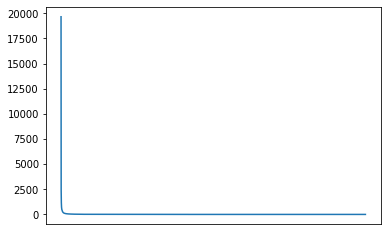

In [3]:
import matplotlib.pyplot as plt
x, y = zip(*freq_list)

plt.plot(x, y)
plt.xticks([])

We can clearly intepret form the graph above that Zipf's Law seems to be followed. We see the high frequency words are extremely lower in number as compared to words across the corpus. 

Task B: Find the top 10 brands from frequency counts. You will need to write a script to count the frequencies of words (stopwords should NOT be counted). Replace frequently occurring car models with brands so that from now on you have to deal with only brands and not models. You will need another script for this job. A list of model and brand names (not exhaustive) are provided in a separate file.

In [13]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

data2 = data.copy()
data2 = data2.dropna()

def removepuns(item):
    for p in punctuation:
        item = item.lstrip().replace(p,'')
    return item.lower()

data2['comment'] = data2['comment'].apply(removepuns)

cars = pd.read_csv("car models and brands (3).csv")

def modelToBrand(q):
    for i in cars.index.values:
        q = q.replace(cars['Model'][i].lower(), cars['Brand'][i].lower())
    return q

data2['comment'] = data2['comment'].apply(modelToBrand)

stop_words = set(stopwords.words('english'))

def remove(x):
    word_tokens = word_tokenize(x) 
    temp_new = [w.lower() for w in word_tokens if not w.lower() in stop_words] 
    return temp_new

data2['comment'] = data2['comment'].apply(remove)

In [54]:
count = []
for elem in data2['comment']:
    count+=elem

import nltk
from nltk import FreqDist
word_freq = nltk.FreqDist(count)

brand_list = cars["Brand"].unique()

top_words = word_freq.most_common()
top_brands = []

for (key, items) in top_words:
    if key in brand_list:
        model_counts = (key,items)
        top_brands.append(model_counts) 

top_brands

# top 10 = Honda, Ford, Toyota, Hyundai, Kia, Nissan, Mazda, Chevrolet, Volkswagen, Subaru
# next 10 = Chrysler, Acura, BMW, Dodge, Audi, Buick, Infiniti, Lincoln, Mercedes-Benz, Volvo
# next 6 = Pontiac, Cadillac, Mitsubishi, Suzuki, Saturn, Mercury

[('car', 1908),
 ('honda', 1380),
 ('ford', 910),
 ('toyota', 703),
 ('hyundai', 632),
 ('kia', 469),
 ('nissan', 466),
 ('mazda', 409),
 ('sedan', 394),
 ('chevrolet', 378),
 ('seat', 343),
 ('volkswagen', 336),
 ('subaru', 334),
 ('problem', 295),
 ('chrysler', 244),
 ('acura', 205),
 ('bmw', 168),
 ('dodge', 123),
 ('audi', 117),
 ('buick', 116),
 ('infiniti', 48),
 ('lincoln', 46),
 ('mercedes-benz', 36),
 ('volvo', 23),
 ('pontiac', 20),
 ('cadillac', 19),
 ('mitsubishi', 13),
 ('suzuki', 9),
 ('saturn', 7),
 ('mercury', 5)]

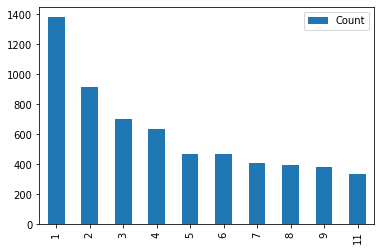

In [177]:
df100 = pd.DataFrame(top_brands, columns = ['Brand', 'Count'])
df100.drop([0, 10, 13])[:10].plot(kind = 'bar')

Task C: Calculate lift ratios for associations between the top-10 brands identified in Task A. You will have to write a script to do this task). For lift calculations, be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post.

In [119]:
ten = [('honda', 1380), ('ford', 910), ('toyota', 703), ('hyundai', 632), ('kia', 469), ('nissan', 466),
                     ('mazda', 409), ('chevrolet', 378), ('volkswagen', 336), ('subaru', 334)]
ten1 = ['honda', 'ford', 'toyota', 'hyundai', 'kia', 'nissan', 'mazda', 'chevrolet', 'volkswagen', 'subaru']

df2 = pd.DataFrame(columns = ten1)

In [120]:
def mention(a):
    if brand in a:
        return 1
    else:
        return 0

for brand in ten1:
    df2[brand] = data2['comment'].apply(brand_mentioned)    

In [121]:
df3 = pd.DataFrame(columns = ten1)

for i in range(len(ten1)):
    new_list = []
    
    for j in range(len(ten1)):
        
        if (i!=j):
            
            numerator = ((df2[ten1[i]] + df2[ten1[j]]) > 1).sum()
            denominator = df2[ten1[j]].sum()*df2[ten1[i]].sum()
            
            lift = numerator*len(df2)/denominator
            
            df3.loc[ten1[i], ten1[j]] = lift

df3

,honda,ford,toyota,hyundai,kia,nissan,mazda,chevrolet,volkswagen,subaru
honda,NaN,1.33114,2.10887,1.67066,1.7116,2.12611,1.56485,1.59752,1.87254,1.77549
ford,1.33114,NaN,1.93444,1.70926,1.87071,1.91805,1.07257,2.13248,2.02368,1.83878
toyota,2.10887,1.93444,NaN,2.75166,2.45181,3.2749,1.82226,2.72284,2.42943,3.01778
hyundai,1.67066,1.70926,2.75166,NaN,3.88886,2.84647,1.23549,2.69452,2.74935,2.76581
kia,1.7116,1.87071,2.45181,3.88886,NaN,2.76266,1.79495,3.01176,2.65991,2.38914
nissan,2.12611,1.91805,3.2749,2.84647,2.76266,NaN,1.78033,3.14446,3.21882,2.62895
mazda,1.56485,1.07257,1.82226,1.23549,1.79495,1.78033,NaN,1.42016,1.96079,2.11865
chevrolet,1.59752,2.13248,2.72284,2.69452,3.01176,3.14446,1.42016,NaN,3.41813,3.00383
volkswagen,1.87254,2.02368,2.42943,2.74935,2.65991,3.21882,1.96079,3.41813,NaN,3.82396
subaru,1.77549,1.83878,3.01778,2.76581,2.38914,2.62895,2.11865,3.00383,3.82396,NaN


Task D: Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on GitHub). 

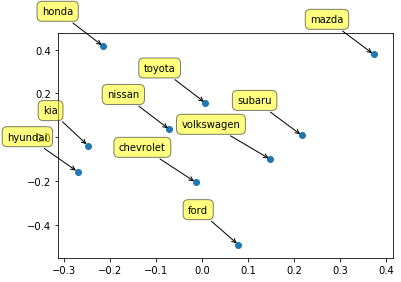

In [122]:
import numpy as np

# Calculating the dissimilarity matrix which is the input for plotting MDS plot

dissimilarity_matrix = 1/df3
np.fill_diagonal(dissimilarity_matrix.values, 0)

# Plotting MDS plot

from sklearn import manifold
seed = np.random.RandomState(seed=3)

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
      random_state=seed, dissimilarity="precomputed", n_jobs=1)

results = mds.fit(dissimilarity_matrix)
coords = results.embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )
for label, x, y in zip(ten1, coords[:, 0], coords[:, 1]):
    
    plt.annotate(
        label,
        xy = (x, y), xytext = (-30, 30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

plt.show()

Task E: What insights can you offer to your client from your analyses in Tasks C and D 

Noting some factual information about the top brands and looking at the split by manfacturer origin:
1. Japanese - Honda, Toyota, Nissan, Mazda (parent: Toyota), Subaru
2. American - Ford, Chevy (parent: GM)
3. South Korean - Hyundai, Kia (parent: Hyundai)
4. German - Volkswagen

Looking at the lift association values and MDS plot, we can note that the brands coming from same parent organization or same manufacturer country seem to have the highest associations which looks like a sensible pattern in this problem. 



Task F: What are 5 most frequently mentioned attributes or features of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.

In [150]:
# consider the top attribute-like word list from freq_list 

att = {'mpg': 463, 'interior': 324, 'Legacy': 224, 'turbo': 185, 'feel': 185, 'love': 182, 
                           'Sport': 180, 'speed': 147, 'steering': 123, 'quality': 113} # in order of frequency

att1 = ['mpg', 'interior', 'legacy', 'turbo', 'feel', 'love', 'sport', 'speed', 'steering', 'quality']

In [151]:
att_df = pd.DataFrame(columns = att1)

def att_mention(a):
    if attribute in a:
        return 1
    else:
        return 0
      
for attribute in att1:
    att_df[attribute] = data2['comment'].apply(att_mention)  
    
df4 = pd.DataFrame(columns = att1)

for i in range(len(ten1)):
    new_list = []
    
    for j in range(len(att1)):
        numerator = ((df2[ten1[i]] + att_df[att1[j]]) > 1).sum()
        denominator = df2[ten1[i]].sum() * att_df[att1[j]].sum()
        
        lift1 = numerator*len(att_df)/denominator
        df4.loc[ten1[i],att1[j]] = lift1

print ('Below are the lift ratios between top 5 brands and top 5 attributes \n')
df4

Below are the lift ratios between top 5 brands and top 5 attributes 



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


,mpg,interior,legacy,turbo,feel,love,sport,speed,steering,quality
honda,1.71416,1.52008,NaN,1.45828,1.49773,1.53526,2.55243,1.38611,1.75821,1.73264
ford,1.33208,1.46693,NaN,1.76014,1.39521,1.43981,1.15584,1.21856,1.40861,1.78976
toyota,1.17186,2.0345,NaN,1.16842,1.76404,1.34825,1.46138,1.06472,2.08386,2.26746
hyundai,1.69457,1.7853,NaN,1.6246,1.58846,1.23506,1.74167,1.05274,1.66604,1.69974
kia,1.20449,1.66033,NaN,2.53951,2.39235,2.43702,2.39914,1.12308,2.73312,2.95546
nissan,1.18699,1.73922,NaN,0.925396,1.77413,1.67502,1.46975,1.07082,1.08064,1.48724
mazda,0.949566,2.29245,NaN,2.15893,1.73261,2.38557,2.15303,1.15227,2.01476,2.54177
chevrolet,1.12084,2.10208,NaN,1.62976,0.937353,1.25373,1.1648,1.17343,1.21111,1.19176
volkswagen,1.50613,2.31754,NaN,2.44464,1.31815,1.49342,2.184,1.32011,0.817497,2.7846
subaru,1.72657,2.23626,NaN,1.22964,2.47529,1.33543,1.97737,1.82601,2.87837,1.76376


Task G: What advice will you give to your client from Task F? For this assignment, you can assume that all sentiments are positive. 

Considering the five most frequent attributes as [mpg, interor, turbo, speed and steering], it can be noted that:
1. All except mazda seem to perform equally in terms of mileage, and there's a clear half and half for interior.
2. Kia (closely followed by volkwagen) leads with turbo, while Nissan performs the worst
3. Speed seems to be equally talked about for all the brands while steering comes in with Toyota, Kia, Mazda and Subaru.

Task H: Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

Considering the words [Legacy, feel, love, Sport, Quality] as indicative of aspiration, it's not very surprsing to note that none of the top brands are associated with legacy. Kia and Subaru seem to have more association with "feel" but it's hard to comment on the positive or negative sentiment without further analysis. Kia and Mazda show more with the word "love". While Honda takes away the lead for sport, I wonder if it is because of the fact that it has been creating a bit of buzz within motorsports, particualrly Formula one. Finally, toyota, kia, mazda and volkwagen tend to be paired with quality. 